In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import mdtraj as md
import pyemma
plt.rc('font', family='serif')

In [56]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories

In [57]:
print(AlanineDipeptide().description())

The dataset consists of ten 10ns trajectories of of alanine dipeptide,
simulated using OpenMM 6.0.1 (CUDA platform, NVIDIA GTX660) with the
AMBER99SB-ILDN force field at 300K (langevin dynamics, friction coefficient
of 91/ps, timestep of 2fs) with GBSA implicit solvent. The coordinates are
saved every 1ps. Each trajectory contains 9,999 snapshots.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026131



In [58]:
# for alanine dipeptide, we can explicitly compute the corresponding feature vector
# for larger proteins, we will not be able to compute the feature vector, since its
# size is (n_atoms choose 3)

In [60]:
traj = trajs[0]
traj.xyz.shape
X = traj.xyz[0]
X.shape

(22, 3)

In [53]:
from itertools import product

In [69]:
def grassman_vector(X):
    ''' Explicitly featurize'''
    return np.array([np.linalg.det(X[np.array(s)]) for s in product(*[(False,True)]*len(X)) if sum(s)==3])

In [72]:
%%time
grassman_vector(X)

CPU times: user 2.93 s, sys: 70.7 ms, total: 3 s
Wall time: 2.95 s


array([ 0.00070261,  0.00119936,  0.00969827, ...,  0.01734438,
       -0.00088424, -0.00892292], dtype=float32)

In [61]:
# what if we precompute the indices
indices = [np.array(s) for  s in product(*[(False,True)]*len(X)) if sum(s)==3]

def grassman_vector_(X):
    ''' Explicitly featurize'''
    return np.array([np.linalg.det(X[s]) for s in indices])

In [62]:
%%time
grassman_vector_(X)
# much better!

CPU times: user 21 ms, sys: 1.83 ms, total: 22.9 ms
Wall time: 21.4 ms


array([ 0.00070261,  0.00119936,  0.00969827, ...,  0.01734438,
       -0.00088424, -0.00892292], dtype=float32)

In [75]:
def grassman_featurize(trajs):
    indices = [np.array(s) for  s in product(*[(False,True)]*trajs[0].n_atoms) if sum(s)==3]
    return [np.array([grassman_vector_(x) for x in traj.xyz]) for traj in trajs]

In [79]:
%%time
X_grassman = grassman_featurize(trajs)

CPU times: user 34min 35s, sys: 4.37 s, total: 34min 40s
Wall time: 37min


In [80]:
np.save('X_grassman_alanine.npy',X_grassman)

In [7]:
X_grassman = np.load('X_grassman_alanine.npy')
X_grassman = [x for x in X_grassman]

In [5]:
X_grassman[0].shape

(9999, 1540)

In [68]:
tica = pyemma.coordinates.tica(X_grassman)

calculate covariances: 100% (20/20) [##############################] eta 00:01 |

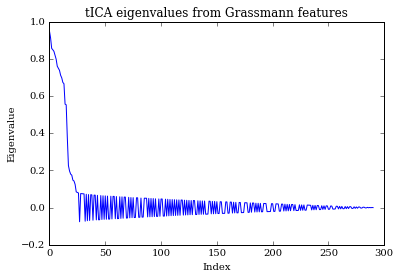

In [134]:
plt.plot(tica.eigenvalues)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('tICA eigenvalues from Grassmann features')
plt.savefig('ala_tica_eigenvalues_grassmann.jpg',dpi=300)

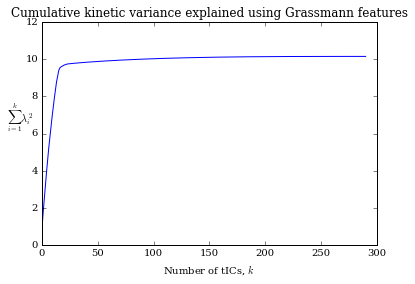

In [138]:
plt.plot(np.cumsum(tica.eigenvalues**2))
plt.xlabel(r'Number of tICs, $k$')
plt.ylabel(r'$\sum_{i=1}^k \lambda_i^2$',rotation=0)
plt.title('Cumulative kinetic variance explained using Grassmann features')
plt.savefig('ala_tica_kin_var_grassmann.jpg',dpi=300)

In [9]:
X_tica = tica.get_output()

getting output of TICA: 100% (20/20) [#############################] eta 00:00 |

In [12]:
np.sum(tica.eigenvalues[:20])

13.108936448870171

In [17]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=100,max_iter=1000)

kmeans iterations:  49% ( 496/1000) [##############                ] eta 00:54 /08-05-16 11:38:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3] INFO     Cluster centers converged after 497 steps.
kmeans iterations: 100% (1000/1000) [##############################] eta 00:00 |

In [18]:
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

getting output of MiniBatchKmeansClustering: 100% (20/20) [########] eta 00:01 |

estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 -

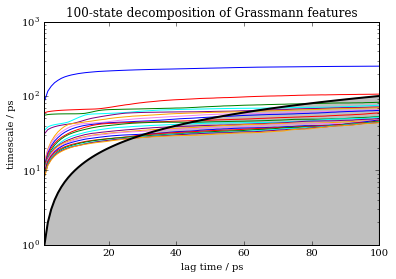

In [31]:
nits=20
its = pyemma.msm.its(dtrajs,lags=range(1,101),nits=nits)
pyemma.plots.plot_implied_timescales(its,units='ps')
plt.title('100-state decomposition of Grassmann features')
plt.savefig('ala_grassmann_kmeans.jpg',dpi=300)

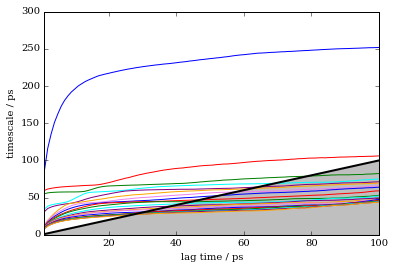

In [26]:
pyemma.plots.plot_implied_timescales(its,units='ps',ylog=False)

In [116]:
evecs = tica.eigenvectors[:,:20]

In [72]:
def random_feature_indices(total_features,n_select=1000):
    all_indices = np.arange(total_features)
    npr.shuffle(all_indices)
    feature_ind = np.zeros(total_features,dtype=bool)
    feature_ind[all_indices[:n_select]] = True
    return feature_ind

calculate covariances: 100% (20/20) [##############################] eta 00:00 -

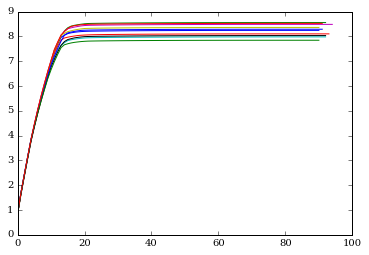

In [48]:
curves = []
for i in range(10):
    feature_mask = random_feature_indices(X_grassman[0].shape[1],n_select=100)
    tica = pyemma.coordinates.tica([x[:,feature_mask] for x in X_grassman],var_cutoff=1.0)
    curves.append(np.cumsum(tica.eigenvalues**2))
for curve in curves:
    plt.plot(curve)
#curves = np.array(curves)

calculate covariances: 100% (20/20) [##############################] eta 00:00 -

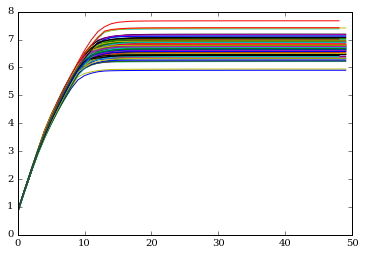

In [51]:
curves = []
for i in range(100):
    feature_mask = random_feature_indices(X_grassman[0].shape[1],n_select=50)
    tica = pyemma.coordinates.tica([x[:,feature_mask] for x in X_grassman],var_cutoff=1.0)
    curves.append(np.cumsum(tica.eigenvalues**2))
for curve in curves:
    plt.plot(curve)

In [ ]:
# how does the total explained kinetic variance depend on the number of features selected?

In [55]:
tot_kin_var = np.array([curve[-1] for curve in curves])
tot_kin_var.mean(),tot_kin_var.std()

(6.7063362740223385, 0.29793759146714877)

In [73]:
n_features = [5,10,20,50,100,200,400,600,800,1000]
all_curves = dict()
n_replicates = 100

for n_select in n_features:
    curves = []
    for i in range(n_replicates):
        feature_mask = random_feature_indices(X_grassman[0].shape[1],n_select=n_select)
        tica = pyemma.coordinates.tica([x[:,feature_mask] for x in X_grassman],var_cutoff=1.0)
        curves.append(np.cumsum(tica.eigenvalues**2))
    all_curves[n_select] = curves

calculate mean: 100% (20/20) [#####################################] eta 00:01 |Traceback (most recent call last):
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
 

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [116]:
n_features[:7]

[5, 10, 20, 50, 100, 200, 400]

In [81]:
n_replicates = 10

for n_select in n_features[7:]:
    print(n_select)
    curves = []
    for i in range(n_replicates):
        print(i)
        feature_mask = random_feature_indices(X_grassman[0].shape[1],n_select=n_select)
        tica = pyemma.coordinates.tica([x[:,feature_mask] for x in X_grassman],var_cutoff=1.0)
        curves.append(np.cumsum(tica.eigenvalues**2))
    all_curves[n_select] = curves

600
0
calculate covariances: 100% (20/20) [##############################] eta 00:00 |1
calculate covariances: 100% (20/20) [##############################] eta 00:00 |2
calculate covariances: 100% (20/20) [##############################] eta 00:00 |3
calculate covariances: 100% (20/20) [##############################] eta 00:01 |4
calculate covariances: 100% (20/20) [##############################] eta 00:00 |5
calculate covariances: 100% (20/20) [##############################] eta 00:01 |6
calculate covariances: 100% (20/20) [##############################] eta 00:00 |7
calculate covariances: 100% (20/20) [##############################] eta 00:00 |8
calculate covariances: 100% (20/20) [##############################] eta 00:00 |9
calculate covariances: 100% (20/20) [##############################] eta 00:00 |800
0
calculate covariances: 100% (20/20) [##############################] eta 00:00 |1
calculate covariances: 100% (20/20) [##############################] eta 00:00 |2
calcul

In [ ]:
n_replicates = 10

for n_select in n_features[7:]:
    print(n_select)
    curves = []
    for i in range(n_replicates):
        print(i)
        feature_mask = random_feature_indices(X_grassman[0].shape[1],n_select=n_select)
        tica = pyemma.coordinates.tica([x[:,feature_mask] for x in X_grassman],var_cutoff=1.0)
        curves.append(np.cumsum(tica.eigenvalues**2))
    all_curves[n_select] = curves

In [88]:
mean_kin_var = [np.array([curve[-1] for curve in all_curves[n]]).mean() for n in n_features]
std_kin_var = [np.array([curve[-1] for curve in all_curves[n]]).std() for n in n_features]

In [93]:
# add total n_features
lags.append(1540)
mean_kin_var.append(np.sum(tica.eigenvalues**2))
std_kin_var.append(0)

In [95]:
n_features.append(1540)

In [106]:
fractions = np.array(n_features) / 1540.0

In [109]:
fractions

array([ 0.00324675,  0.00649351,  0.01298701,  0.03246753,  0.06493506,
        0.12987013,  0.25974026,  0.38961039,  0.51948052,  0.64935065,  1.        ])

In [113]:
tica = pyemma.coordinates.tica(X_grassman,var_cutoff=1.0)
tot_var = np.sum(tica.eigenvalues**2)

calculate covariances: 100% (20/20) [##############################] eta 00:00 |

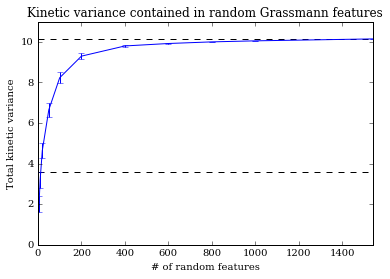

In [115]:
plt.errorbar(n_features,mean_kin_var,yerr=std_kin_var)
#plt.plot(n_features,mean_kin_var,'.')
plt.hlines(tot_var,0,1540,linestyles='--')
plt.hlines(3.59,0,1540,linestyles='--')
plt.xlim(0,1540)
plt.ylim(0,11)
plt.xlabel('# of random features')
plt.ylabel('Total kinetic variance')
plt.title('Kinetic variance contained in random Grassmann features')
plt.savefig('kinetic_var_explained_ala_g.jpg',dpi=300)
#plt.xticks(n_features,fractions)

In [ ]:
# so, about 20 randomly selected Grassmann features are better than exhaustive structural features
# and about 200 randomly selected Grassmann features are better than 

In [ ]:
# how does the number of retained tICs depend on the number of input features?

In [47]:
[len(c) for c in curves]

[92, 94, 92, 92, 95, 94, 95, 91, 91, 90]

In [ ]:
# what does 

subset_sizes = [10,100,500,1000]
for i in range(10):
    

In [84]:
feature_mask = random_feature_indices(X_grassman[0].shape[1],n_select=1540)
tica = pyemma.coordinates.tica([x[:,feature_mask] for x in X_grassman],var_cutoff=1.0)
np.sum(tica.eigenvalues**2)

calculate covariances: 100% (20/20) [##############################] eta 00:00 |

10.147323961245789

In [32]:
X_grassman[0].shape

(9999, 1540)

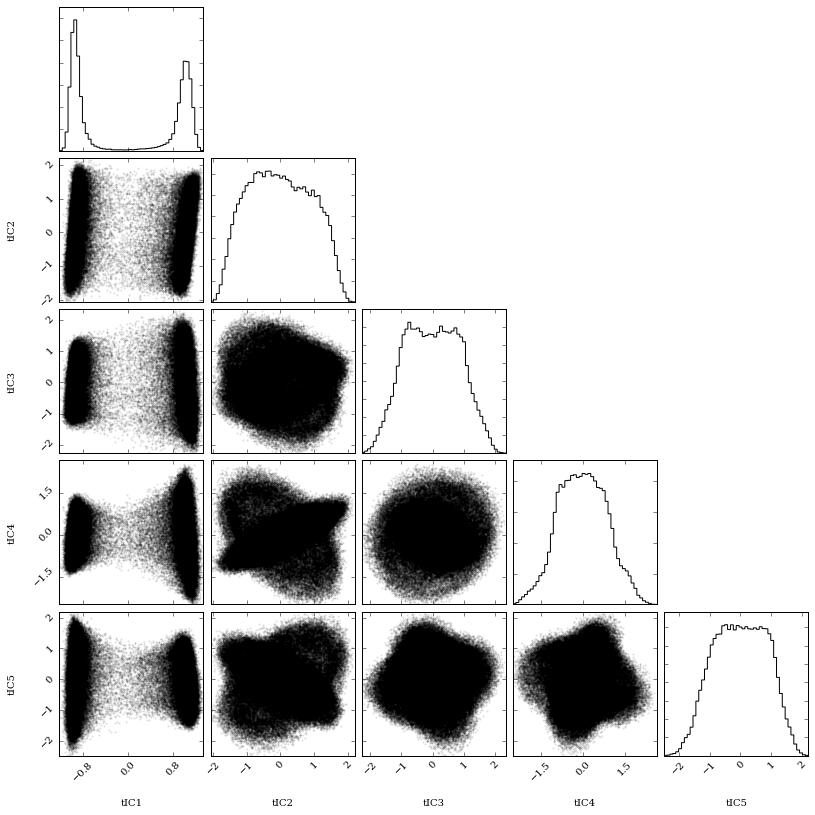

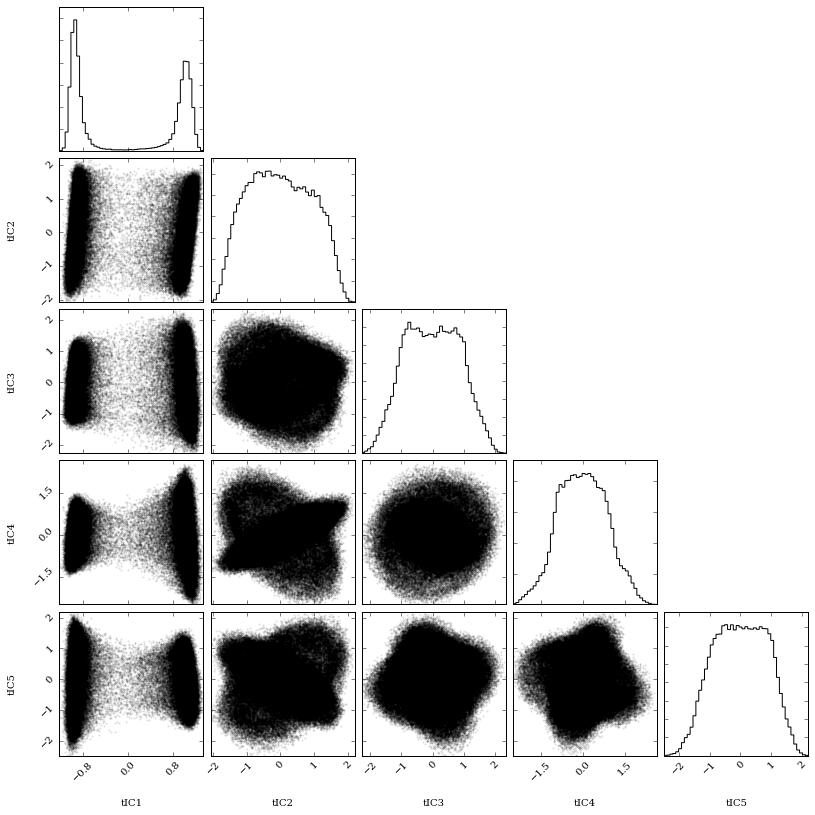

In [120]:
import triangle
Y_tica = np.vstack(X_tica)
n_tics=5
triangle.corner(Y_tica[:,:n_tics],
                plot_contours=False,
                labels=['tIC{0}'.format(i+1) for i in range(n_tics)]
               )

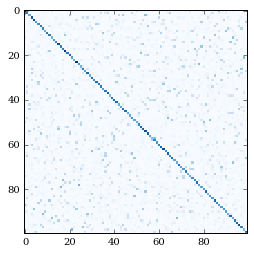

In [133]:
lag_time=20
msm = pyemma.msm.estimate_markov_model(dtrajs,lag_time)
plt.imshow(msm.transition_matrix,interpolation='none',cmap='Blues')

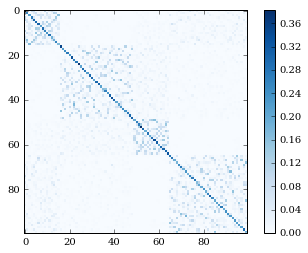

In [155]:
def plot_contiguous(T,mapping):
    sorted_inds = np.array(sorted(range(len(T)),key=lambda i:mapping[i]))
    plt.imshow(T[sorted_inds][:,sorted_inds],interpolation='none',cmap='Blues')
    plt.colorbar()
    
from sklearn.cluster import SpectralBiclustering
cocluster = SpectralBiclustering(4,svd_method='arpack')
cocluster.fit(msm.transition_matrix)
plot_contiguous(msm.transition_matrix,cocluster.row_labels_)

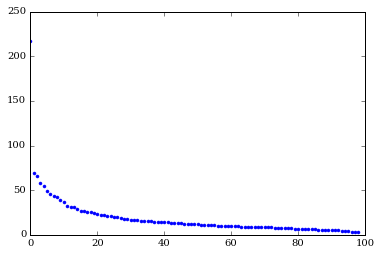

In [142]:
plt.plot(msm.timescales(),'.')

In [135]:
np.trace(msm.transition_matrix)

25.371754167409943

In [118]:
from msmbuilder.cluster import MiniBatchKMedoids
kmed = MiniBatchKMedoids(n_clusters=100,metric='rmsd')
dtrajs_rmsd = kmed.fit_transform(trajs)

4.503837576535366

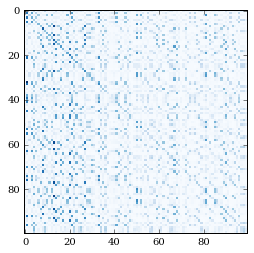

In [119]:
lag_time=20
msm_rmsd = pyemma.msm.estimate_markov_model(dtrajs_rmsd,lag_time)
plt.imshow(msm_rmsd.transition_matrix,interpolation='none',cmap='Blues')
np.trace(msm_rmsd.transition_matrix)

In [120]:
from sklearn
T = msm_rmsd.transition_matrix
cocluster = SpectralBiclustering(4,svd_method='arpack')
cocluster.fit(T)
plot_contiguous(T,cocluster.row_labels_)

NameError: name 'SpectralBiclustering' is not defined

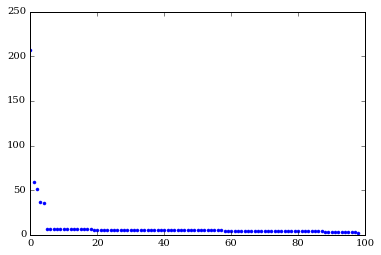

In [121]:
plt.plot(msm_rmsd.timescales(),'.')

estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 -

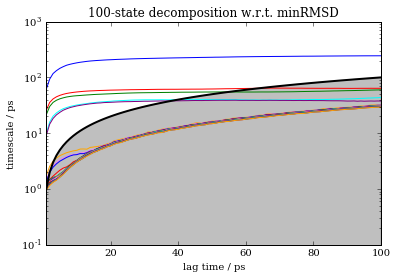

In [124]:
nits=20
its = pyemma.msm.its(dtrajs_rmsd,lags=range(1,101),nits=nits)
pyemma.plots.plot_implied_timescales(its,units='ps')
plt.title('100-state decomposition w.r.t. minRMSD')
plt.savefig('ala_rmsd_kmeds.jpg',dpi=300)

So this is promising! The Binet-Cauchy kernel corresponds to dot-products in a useful feature-space.

Here, we explicitly computed those features, and weighted them optimally using tICA. The resulting discretization 

It would be useful if we knew how to weight the features for large systems.

In [125]:
# can I do this with the MetEnkephalin example data?
from msmbuilder.example_datasets import MetEnkephalin
print(MetEnkephalin().description())
met = MetEnkephalin().get().trajectories
n_atoms = met[0].n_atoms
print(n_atoms/3)
from math import factorial
bin_coeff = lambda m,k=3:factorial(m)/(factorial(m-k)*factorial(k))
bin_coeff(25)

The dataset consists of ten ~50 ns molecular dynamics (MD) simulation
trajectories of the 5 residue Met-enkaphalin peptide. The aggregate
sampling is 499.58 ns. Simulations were performed starting from the 1st
model in the 1PLX PDB file, solvated with 832 TIP3P water molecules using
OpenMM 6.0. The coordinates (protein only -- the water was stripped)
are saved every 5 picoseconds. Each of the ten trajectories is roughly
50 ns long and contains about 10,000 snapshots.

Forcefield: amber99sb-ildn; water: tip3p; nonbonded method: PME; cutoffs:
1nm; bonds to hydrogen were constrained; integrator: langevin dynamics;
temperature: 300K; friction coefficient: 1.0/ps; pressure control: Monte
Carlo barostat (interval of 25 steps); timestep 2 fs.

The dataset is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026324

25


2300L

In [126]:
%%time
from msmbuilder.cluster import MiniBatchKMedoids
kmed = MiniBatchKMedoids(n_clusters=100,metric='rmsd')
dtrajs_rmsd_met = kmed.fit_transform(met)

CPU times: user 36.6 s, sys: 115 ms, total: 36.8 s
Wall time: 36.8 s


estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 \

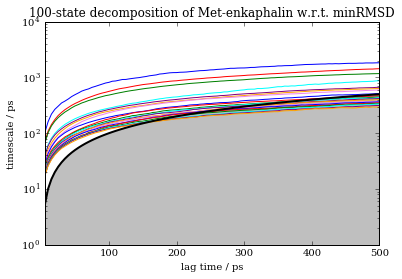

In [127]:
nits=20
its = pyemma.msm.its(dtrajs_rmsd_met,lags=range(1,101),nits=nits)
pyemma.plots.plot_implied_timescales(its,units='ps',dt=5)
plt.title('100-state decomposition of Met-enkaphalin w.r.t. minRMSD')
plt.savefig('met_rmsd_kmeds.jpg',dpi=300)

In [167]:
n_atoms = met[0].n_atoms
stride = 3
trajs_reduced_atoms = [traj.atom_slice(range(n_atoms)[::stride]) for traj in met]

In [168]:
trajs_reduced_atoms[0]

<mdtraj.Trajectory with 9979 frames, 25 atoms, 5 residues, and unitcells at 0x164355e10>

In [170]:
indices = [np.array(s) for  s in product(*[(False,True)]*trajs_reduced_atoms[0].n_atoms) if sum(s)==3]
len(indices)

2300

In [173]:
%%time
# compute explicit grassman features
X_grassman_met = [np.array([grassman_vector_(x) for x in traj.xyz]) for traj in trajs_reduced_atoms]

CPU times: user 53min 20s, sys: 9.95 s, total: 53min 30s
Wall time: 53min 50s


getting output of TICA: 100% (22/22) [#############################] eta 00:00 |

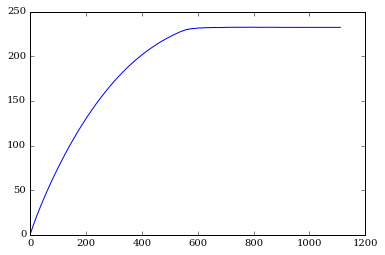

In [219]:
np.save('X_grassman_met.npy',X_grassman_met)
tica = pyemma.coordinates.tica(X_grassman_met)
X_tica = tica.get_output()

plt.plot(np.cumsum(tica.eigenvalues))

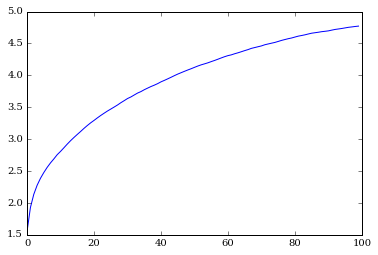

In [23]:
# distance decay plots
# unweighted BC
# rmsd
# optimally weighted BC
from scipy.spatial.distance import euclidean

def distance_decay(X,lags=range(1,101)):
    max_lag = max(lags)
    distances = np.zeros((len(X) - max_lag,len(lags)))
    for i in range(len(distances)):
        for j in range(len(lags)):
            distances[i,j] = euclidean(X[i],X[i+lags[j]])
    return distances

def distance_decay_multiseq(Xs,lags=range(1,101)):
    distances = []
    for X in Xs:
        distances.append(distance_decay(X,lags))
    return np.vstack(distances)

distances = distance_decay(X_grassman[0])
plt.plot(distances.mean(0))

In [46]:
def distance_decay_plot(distances,lags,c='blue',label=''):
    n = len(distances)
    mean = distances.mean(0)
    stdev = distances.std(0)
    stderr = stdev / np.sqrt(n) # standard error of the mean
    
    err = stderr
    
    plt.plot(lags,mean,color=c,label=label)
    plt.fill_between(lags,mean-err,mean+err,alpha=0.5,color=c)

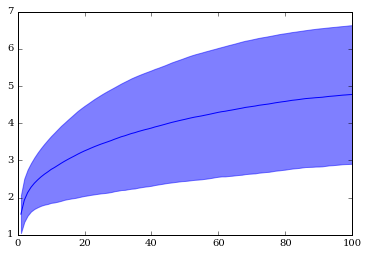

In [37]:
lags = range(1,101)
distance_decay_plot(distances,lags)

In [42]:
lags = range(1,501)[::10]

distances_g = distance_decay_multiseq(X_grassman,lags)

distances_t = distance_decay_multiseq(X_tica,lags)

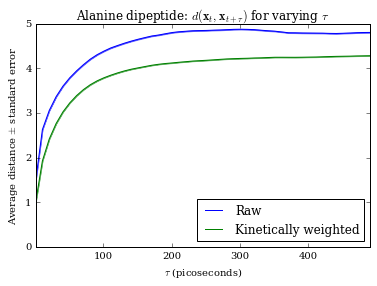

In [51]:
distance_decay_plot(distances_g,lags,'blue', label='Raw')
distance_decay_plot(distances_t,lags,'green', label='Kinetically weighted')

plt.xlim(min(lags),max(lags))
plt.ylim(0,5)

plt.xlabel(r'$\tau$ (picoseconds)')
plt.ylabel(r'Average distance $\pm$ standard error')
plt.title(r'Alanine dipeptide: $d(\mathbf{x}_t,\mathbf{x}_{t+\tau})$ for varying $\tau$')
plt.legend(loc='lower right')
plt.savefig('distance_decay_ala.jpg',dpi=300)

In [4]:
from scipy.spatial.distance import pdist,squareform
pdist_g = pdist(X_grassman[0][::10])

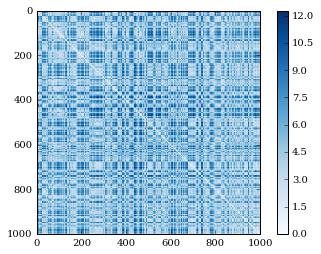

In [12]:
plt.imshow(squareform(pdist_g),interpolation='none',cmap='Blues')
plt.colorbar()

In [10]:
pdist_t = pdist(X_tica[0][::10])

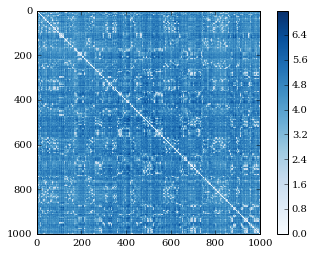

In [13]:
plt.imshow(squareform(pdist_t),interpolation='none',cmap='Blues')
plt.colorbar()

In [3]:
X_grassman[0][::10].shape

(1000, 1540)

In [220]:
X_grassman_met[0].shape

(9979, 2300)

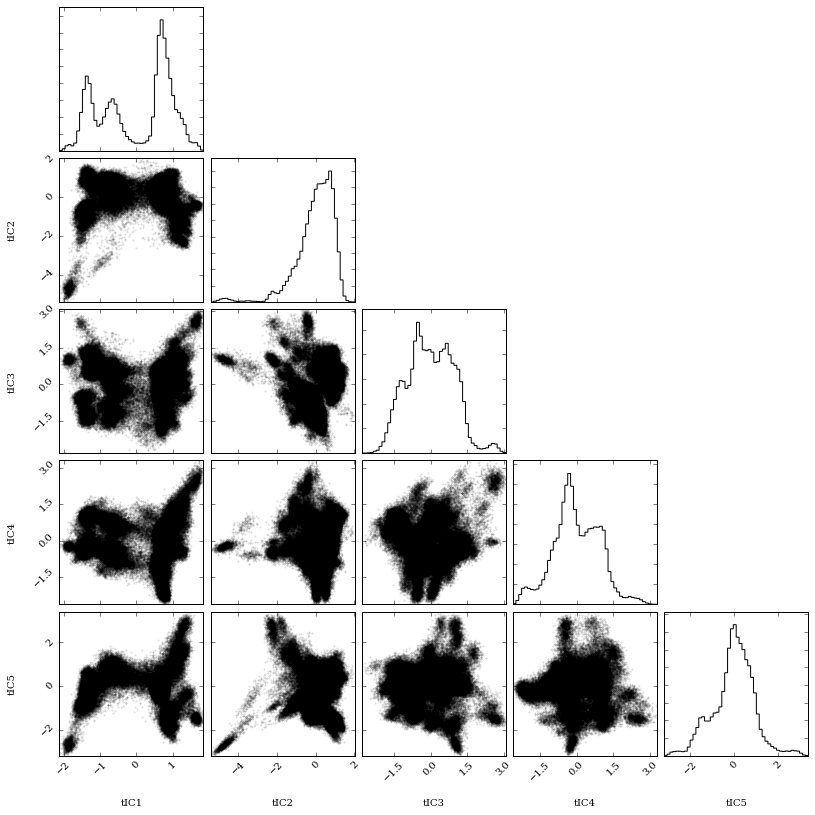

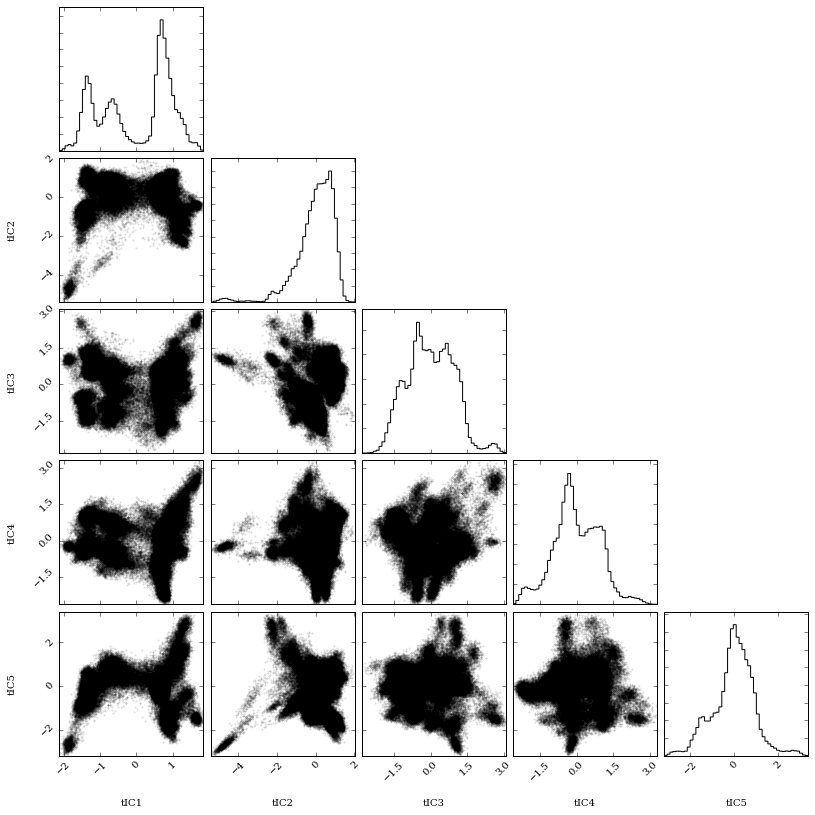

In [175]:
n_tics=5
triangle.corner(np.vstack(X_tica)[:,:n_tics],
                plot_contours=False,
                labels=['tIC{0}'.format(i+1) for i in range(n_tics)]
               )

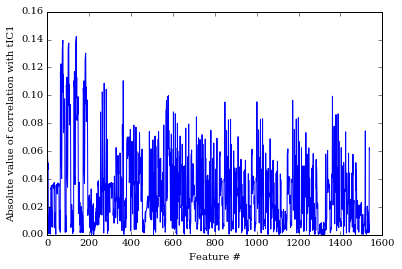

In [69]:
plt.plot(np.abs(tica.feature_TIC_correlation[:,0]))
plt.xlabel('Feature #')
plt.ylabel('Absolute value of correlation with tIC1')

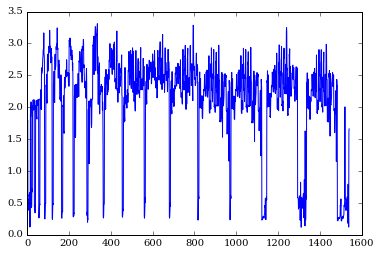

In [70]:
plt.plot(np.abs(tica.feature_TIC_correlation).sum(1))

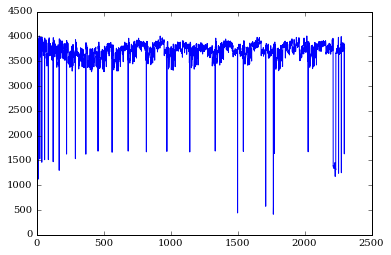

In [196]:
A = np.abs(tica.feature_TIC_correlation)
plt.plot(A.dot(np.arange(428)[::-1]+1))

# hmm, this isn't exactly what I was hoping for -- it seems like only a few features
# are not informative, most are informative

# on the other hand, this might actually be good news for a random approximation -- if I draw some
# features totally at random, they'll likely be informative

kmeans iterations: 100% (200/200) [################################] eta 00:01 |07-05-16 20:56:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[21] INFO     Algorithm did not reach convergence criterion of 1e-05 in 200 iterations. Consider increasing max_iter.
estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 /

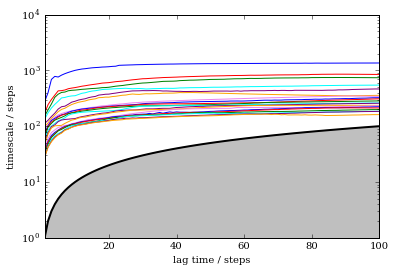

In [222]:
kmeans_met = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=100,max_iter=200)
dtrajs_met = [dtraj.flatten() for dtraj in kmeans_met.get_output()]

its = pyemma.msm.its(dtrajs_met,lags=range(1,101),nits=nits)
pyemma.plots.plot_implied_timescales(its)

estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 -

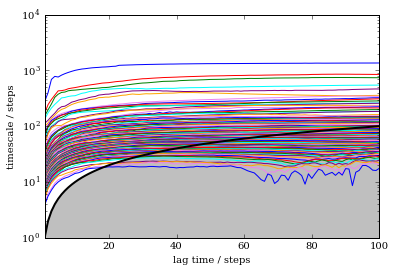

In [224]:
lags = range(1,101)# + range(100,1001)[::10]
its = pyemma.msm.its(dtrajs_met,lags=lags)
pyemma.plots.plot_implied_timescales(its)

estimating MaximumLikelihoodMSM: 100% (191/191) [##################] eta 00:00 -

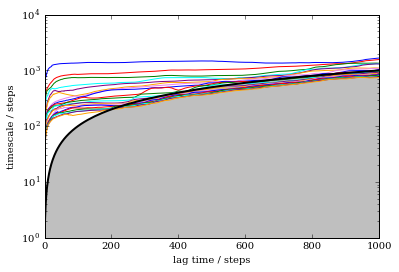

In [225]:
lags = range(1,101) + range(100,1001)[::10]
its = pyemma.msm.its(dtrajs_met,lags=lags,nits=nits)
pyemma.plots.plot_implied_timescales(its)

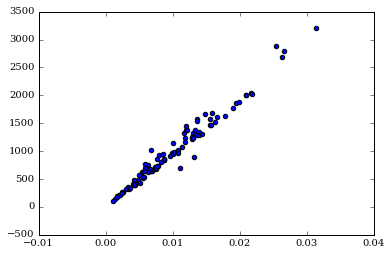

In [226]:
msm = pyemma.msm.estimate_markov_model(dtrajs_met,lag=20)
plt.scatter(msm.stationary_distribution,msm.count_matrix_active.sum(0))

kmeans iterations:  51% ( 515/1000) [###############               ] eta 03:54 /08-05-16 13:17:20 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[274] INFO     Cluster centers converged after 516 steps.
estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 /

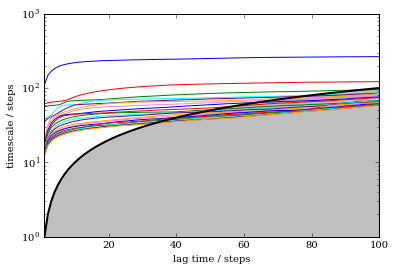

In [56]:
kmeans_met = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=500,max_iter=1000)
dtrajs_met = [dtraj.flatten() for dtraj in kmeans_met.get_output()]

its = pyemma.msm.its(dtrajs_met,lags=range(1,101),nits=nits)
pyemma.plots.plot_implied_timescales(its)

In [180]:
msm = pyemma.msm.estimate_markov_model(dtrajs_met,20)

In [181]:
msm.active_count_fraction

1.0

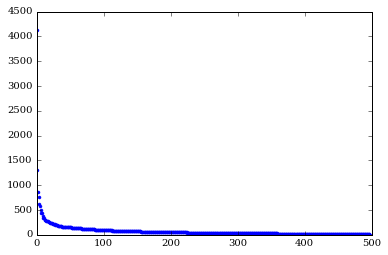

In [182]:
plt.plot(msm.timescales(),'.')

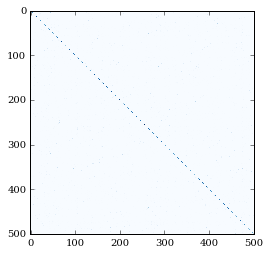

In [183]:
plt.imshow(msm.transition_matrix,interpolation='none',cmap='Blues')

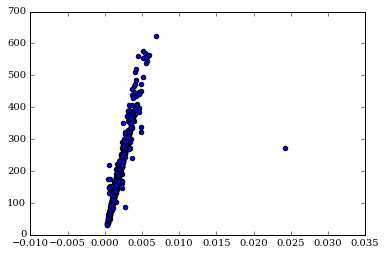

In [185]:
plt.scatter(msm.stationary_distribution,msm.count_matrix_active.sum(0))

In [197]:
def select_random_features(n_atoms,n_features=1000,seed=0):
    npr.seed(0)
    all_indices = np.arange(n_atoms)
    
    feature_indices = []
    for i in range(n_features):
        npr.shuffle(all_indices)
        feature_ind = np.zeros(n_atoms,dtype=bool)
        feature_ind[all_indices[:3]] = True
        feature_indices.append(feature_ind)
    return feature_indices

In [202]:
[sum(f) for f in feature_indices]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [203]:
factorial(75) / (factorial(75 - 3) * factorial(3))

67525L

In [214]:
feature_indices = select_random_features(75,n_features=500)

In [215]:
def grassman_vector_with_indices(X,indices):
    return np.array([np.linalg.det(X[s]) for s in indices])

def grassman_featurize_(trajs,indices):
    return [np.array([grassman_vector_with_indices(x,indices) for x in traj.xyz]) for traj in trajs]

In [216]:
%%time
X_grassman_random_met = grassman_featurize_(met,feature_indices)

CPU times: user 12min 24s, sys: 2.52 s, total: 12min 27s
Wall time: 12min 32s


getting output of TICA: 100% (22/22) [#############################] eta 00:00 /

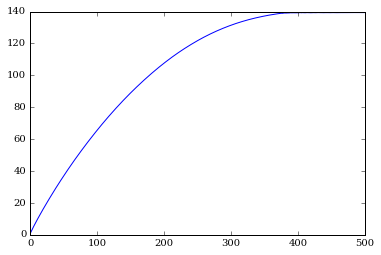

In [217]:
tica_r = pyemma.coordinates.tica(X_grassman_random_met)
X_tica_r = tica_r.get_output()

plt.plot(np.cumsum(tica_r.eigenvalues))

kmeans iterations:  83% ( 83/100) [##########################      ] eta 00:17 |07-05-16 20:38:27 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[18] INFO     Cluster centers converged after 84 steps.
estimating MaximumLikelihoodMSM: 100% (100/100) [##################] eta 00:01 -

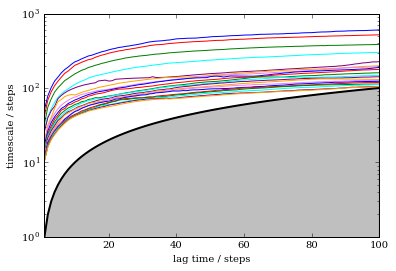

In [218]:
kmeans_met_r = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica_r,k=100,max_iter=100)
dtrajs_met_r = [dtraj.flatten() for dtraj in kmeans_met_r.get_output()]

its = pyemma.msm.its(dtrajs_met_r,lags=range(1,101),nits=nits)
pyemma.plots.plot_implied_timescales(its)